In [35]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.special import erf
import h5py
import os
from unyt import angstrom, Msun, yr, m
from synthesizer.grid import Grid


plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

In [28]:
subvolumes = [
    "0_0_0",
    "0_0_1",
    "0_1_0",
    "0_1_1",
    "1_0_0",
    "1_0_1",
    "1_1_0",
    "1_1_1"
]

subvolumes = ["0_0_0"]  # keep only the ones you want

pipeline_dir = '/mnt/home/snewman/ceph/pipeline_results/combined'
grp = 'Galaxies/Spectra/SpectralLuminosityDensities'

spectra = np.concatenate([
    h5py.File(os.path.join(pipeline_dir, f'pipeline_no_dust_{subvol}.hdf5'), 'r')[f'{grp}/total'][:]
    for subvol in subvolumes
])

print(spectra.shape)

print(spectra)

(141636, 1999)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/tmp/ipykernel_1384927/1344530748.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wavelengths), np.log10(spectra[i]), alpha=0.7)


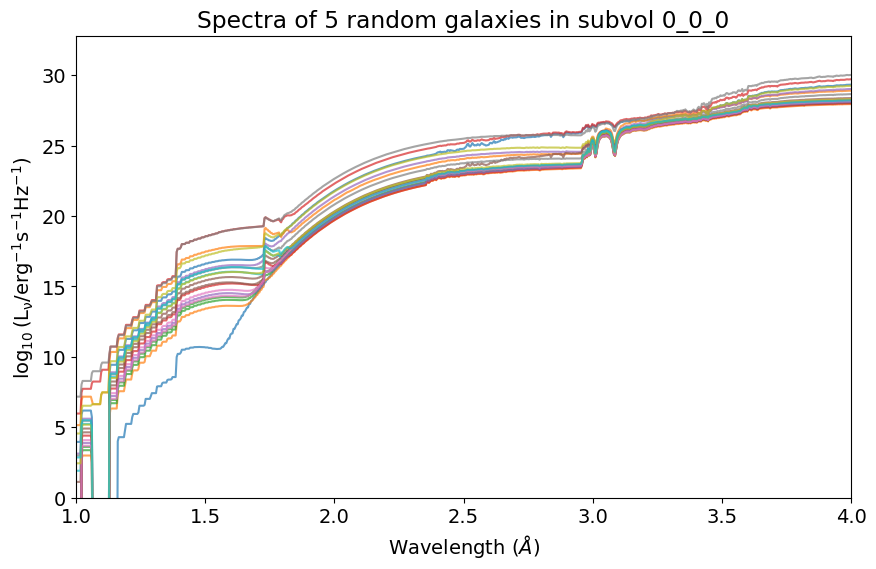

In [31]:
# Get wavelengths from the AGN grid
grid_dir = '/mnt/ceph/users/snewman/grids'
grid_name = 'qsosed.hdf5'
grid_agn = Grid(grid_dir=grid_dir, grid_name=grid_name, ignore_lines=True)
wavelengths = grid_agn.lam

# Pick 5 random galaxies
gal_idx = np.random.choice(spectra.shape[0], 20, replace=False)

plt.figure(figsize=(10, 6))
for i in gal_idx:
    plt.plot(np.log10(wavelengths), np.log10(spectra[i]), alpha=0.7)

plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel(r'$\rm \log_{10}(L_{\nu}/erg^{-1} s^{-1} Hz^{-1})$')
plt.title("Spectra of 5 random galaxies in subvol 0_0_0")
plt.xlim(left=1, right=4)
plt.ylim(bottom=0)
plt.show()

Using wavelength index 1516 wavelength (m) = 1453.4371148994896 Å -> (Å) = 1453.4371148994896 dimensionless


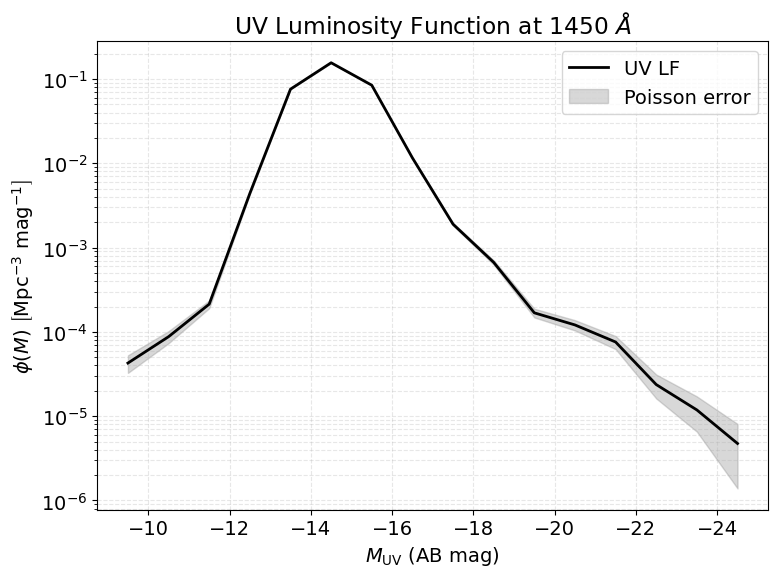

M = -24.50  phi = 4.741e-06 +/- 3.352e-06  (counts=2)
M = -23.50  phi = 1.185e-05 +/- 5.300e-06  (counts=5)
M = -22.50  phi = 2.370e-05 +/- 7.496e-06  (counts=10)
M = -21.50  phi = 7.585e-05 +/- 1.341e-05  (counts=32)
M = -20.50  phi = 1.209e-04 +/- 1.693e-05  (counts=51)
M = -19.50  phi = 1.683e-04 +/- 1.997e-05  (counts=71)
M = -18.50  phi = 6.684e-04 +/- 3.981e-05  (counts=282)
M = -17.50  phi = 1.896e-03 +/- 6.704e-05  (counts=800)
M = -16.50  phi = 1.160e-02 +/- 1.658e-04  (counts=4895)
M = -15.50  phi = 8.451e-02 +/- 4.476e-04  (counts=35654)
M = -14.50  phi = 1.560e-01 +/- 6.081e-04  (counts=65816)
M = -13.50  phi = 7.589e-02 +/- 4.241e-04  (counts=32017)
M = -12.50  phi = 4.397e-03 +/- 1.021e-04  (counts=1855)
M = -11.50  phi = 2.133e-04 +/- 2.249e-05  (counts=90)
M = -10.50  phi = 8.770e-05 +/- 1.442e-05  (counts=37)
M = -9.50  phi = 4.267e-05 +/- 1.006e-05  (counts=18)


In [48]:
# Box size in Mpc
box_size_mpc = 150

# Choose UV reference wavelength (1500 Å)
uv_ref = 1450 * angstrom 

# find index in wavelengths closest to 1500 Å
uv_idx = np.argmin(np.abs(wavelengths - uv_ref))
print("Using wavelength index", uv_idx, "wavelength (m) =", wavelengths[uv_idx], "-> (Å) =", wavelengths[uv_idx]/angstrom)

# Extract L_nu at 1500 Å for all galaxies
Lnu_uv = spectra[:, uv_idx].astype(float) 

# If there are non-positive values, remove them (can't take log)
mask_positive = Lnu_uv > 0
if np.sum(~mask_positive) > 0:
    print(f"Warning: {np.sum(~mask_positive)} galaxies have non-positive Lnu; they will be excluded.")
Lnu_uv = Lnu_uv[mask_positive]

# Convert L_nu [erg s^-1 Hz^-1] to M_AB (AB absolute magnitude)
Muv = -2.5 * np.log10(Lnu_uv) + 51.60

# Set magnitude bins (adjust range & bin width to your data)
bin_width = 1
mag_min, mag_max = np.floor(Muv.min()) - 1, np.ceil(Muv.max()) + 1
bins = np.arange(mag_min, mag_max + bin_width, bin_width)
hist, edges = np.histogram(Muv, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Compute comoving volume 
volume_mpc3 = box_size_mpc**3 / 8  # Mpc^3

# Convert counts to number density phi(M) [Mpc^-3 mag^-1]
phi = hist / (volume_mpc3 * bin_width)

# Poisson errors on counts -> sigma_phi = sqrt(N) / (V * bin_width)
sigma_phi = np.sqrt(hist) / (volume_mpc3 * bin_width)

# For plotting, avoid zeros when using log
positive = phi > 0

# Plot LF as line with shaded error
plt.figure(figsize=(8,6))

plt.plot(bin_centers[positive], phi[positive], color="k", lw=2, label="UV LF")
plt.fill_between(bin_centers[positive],
                 phi[positive] - sigma_phi[positive],
                 phi[positive] + sigma_phi[positive],
                 color="gray", alpha=0.3, label="Poisson error")



# Plot observational data

# Schechter function definition
def schechter(M, phi_star, M_star, alpha):
    """
    M : absolute magnitude array
    phi_star : normalization [Mpc^-3 mag^-1]
    M_star : characteristic magnitude
    alpha : faint-end slope
    """
    term = 10**(0.4*(M_star - M))
    return 0.4 * np.log(10) * phi_star * term**(alpha + 1) * np.exp(-term)

# Table 1 parameters
phi_star = 0.91e-3
phi_star_err = 0.3e-3
M_star = -18.03
alpha = -1.65
alpha_err = 0.08

# Magnitude array for smooth plotting
M_plot = np.linspace(-10, -20, 200)

# Nominal Schechter
phi_sch = schechter(M_plot, phi_star, M_star, alpha)

# Upper and lower bounds (simple ±1σ propagation)
phi_upper = schechter(M_plot, phi_star + phi_star_err, M_star, alpha + alpha_err)
phi_lower = schechter(M_plot, max(phi_star - phi_star_err, 0), M_star, alpha - alpha_err)  # phi* can't be negative

# Plot Schechter fit with error band
#plt.plot(M_plot, phi_sch, color="red", lw=2, label="Schechter fit")
#plt.fill_between(M_plot, phi_lower, phi_upper, color="red", alpha=0.2, label=r"$\pm 1\sigma$ fit")


plt.yscale('log')
plt.xlabel(r'$M_{\rm UV}$ (AB mag)')
plt.ylabel(r'$\phi(M)\ \left[\mathrm{Mpc}^{-3}\ \mathrm{mag}^{-1}\right]$')
plt.title(r'UV Luminosity Function at 1450 $\AA$')
plt.gca().invert_xaxis()   # brighter mags to the left
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print some numbers for reference
for m, p, s in zip(bin_centers[positive], phi[positive], sigma_phi[positive]):
    print(f"M = {m:.2f}  phi = {p:.3e} +/- {s:.3e}  (counts={int((p*volume_mpc3*bin_width))})")